In [1]:
# Import necessary packages 

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, quantum_info
from qiskit import Aer, execute
import math
import random
import numpy as np
from scipy.optimize import minimize
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import random_statevector, Statevector
from math import sqrt, pi
from scipy.optimize import  minimize
import matplotlib.pyplot as plt

Task 1:
https://docs.google.com/document/d/1Ow3v8Y4rYBdgxXNxKV9ZUAM4bwL6211U6DWCcByZ4A4/edit

In this notebook, we will build a parametric quantum circuit that can mimic a given random quantum state.

For this particular task, our goal is to mimic a 4 qubit randomly generated state vector (donoted by phi). The parametric circuit is parametrized by L layers, each layer has an odd gate and an even gate parametrized by theta. We have 8*L variational parameters theta to optimize (4 each for odd and even gates).

The notebook is organized as follows:
1. Setup of the Quantum Circuit
    1.1 Even Gate Function
    1.2 Odd Gate Function
    1.3 L layers of Odd and Even Gates   
2. Random Generation of Variational Parameters
3. Generate Target state phi
4. Implement Cost Function
5. Optimization and final output
6. Bonus

## 1. Setup of the Quantum Circuit


## 1.1 Even Gate Function

In [2]:
#Apply Even Gate function (RZ gates on each qubit parameterized by theta, double qubit gates of CZ)
def apply_even_gate(quantum_circuit, variational_parameters):
    
    # Apply a RZ gate with a phase of variational_parameters 
    for i in range(0,4):
        quantum_circuit.rz(variational_parameters[i], qubits[i])
        
    # Apply CZ gates to a series of control qubits and target qubits    
    quantum_circuit.cz(qubits[0], qubits[1])
    quantum_circuit.cz(qubits[0], qubits[2])
    quantum_circuit.cz(qubits[0], qubits[3])
    quantum_circuit.cz(qubits[1], qubits[2])
    quantum_circuit.cz(qubits[1], qubits[3])
    quantum_circuit.cz(qubits[2], qubits[3])
    
    return quantum_circuit

# 4 qubits
qubits = [0, 1, 2, 3]

# initialize quantum register & quantum circuit of 4 qubits
q = QuantumRegister(4)
qc = QuantumCircuit(q)

#variational parameters theta of length 4, will be initialized later with randoms between 0 and 2*pi
var_parameters = ParameterVector('θ',length=4)

#Apply Even Gate
apply_even_gate(qc, var_parameters)

# Visualize the circuit
print('EVEN GATE:')
qc.draw()

EVEN GATE:


┌──────────┐                  
q0_0: ┤ RZ(θ[0]) ├─■──■──■──────────
      ├──────────┤ │  │  │          
q0_1: ┤ RZ(θ[1]) ├─■──┼──┼──■──■────
      ├──────────┤    │  │  │  │    
q0_2: ┤ RZ(θ[2]) ├────■──┼──■──┼──■─
      ├──────────┤       │     │  │ 
q0_3: ┤ RZ(θ[3]) ├───────■─────■──■─
      └──────────┘

## 1.2 Odd Gate Function

In [3]:
#Apply Odd Gate function (RX gates on each qubit parameterized by theta)
def apply_odd_gate(quantum_circuit, variational_parameters):
    
    # Apply a RX gate with a phase of variational_parameters 
    for i in range(0,4):
        quantum_circuit.rx(variational_parameters[i], qubits[i])
    
    return quantum_circuit
        

qubits = [0, 1, 2, 3]

# initialize quantum register & quantum circuit of 4 qubits
q = QuantumRegister(4)
qc = QuantumCircuit(q)

#variational parameters theta of length 4, will be initialized later with randoms between 0 and 2*pi
var_parameters = ParameterVector('θ',length=4)

#Apply Odd Gate
apply_odd_gate(qc, var_parameters)

# Visualize the circuit
print('ODD GATE:')
qc.draw()

ODD GATE:


┌──────────┐
q1_0: ┤ RX(θ[0]) ├
      ├──────────┤
q1_1: ┤ RX(θ[1]) ├
      ├──────────┤
q1_2: ┤ RX(θ[2]) ├
      ├──────────┤
q1_3: ┤ RX(θ[3]) ├
      └──────────┘

In [4]:
#A single layer of odd and even gates (U1 + U2)
qubits = [0, 1, 2, 3]

# initialize quantum register & quantum circuit of 4 qubits
q = QuantumRegister(4)
qc = QuantumCircuit(q)

#variational parameters theta of length 8, will be initialized later with randoms between 0 and 2*pi
# The first 4 are for odd U1 and the next 4 are for even U2
var_parameters = ParameterVector('θ',length=8)

# Apply odd and even gates to the circuit
qc = apply_odd_gate(qc, var_parameters[0:4])
qc = apply_even_gate(qc, var_parameters[4:8])

# Visualize the circuit
print('U1 + U2:')
print('Odd and Even Layer (L=1)')
qc.draw()


U1 + U2:
Odd and Even Layer (L=1)


┌──────────┐┌──────────┐                  
q2_0: ┤ RX(θ[0]) ├┤ RZ(θ[4]) ├─■──■──■──────────
      ├──────────┤├──────────┤ │  │  │          
q2_1: ┤ RX(θ[1]) ├┤ RZ(θ[5]) ├─■──┼──┼──■──■────
      ├──────────┤├──────────┤    │  │  │  │    
q2_2: ┤ RX(θ[2]) ├┤ RZ(θ[6]) ├────■──┼──■──┼──■─
      ├──────────┤├──────────┤       │     │  │ 
q2_3: ┤ RX(θ[3]) ├┤ RZ(θ[7]) ├───────■─────■──■─
      └──────────┘└──────────┘

## 1.3 L layers of Odd and Even Gates

In [5]:
# Build L layers 

# Specify number of layers
L=3

#A single layer of odd and even gates (U1 + U2)
qubits = [0, 1, 2, 3]

# initialize quantum register & quantum circuit of 4 qubits
q = QuantumRegister(4)
qc = QuantumCircuit(q)

# Each Layer has 8 variational parameters (4 for odd and 4 for even). In total 8*L variational parameters
var_parameters = ParameterVector('θ',length=8*L)

# Functions applies L layers
def apply_L_layers(quantum_circuit, variational_parameters, layer):
    
    # Apply odd and even gates to the circuit L times
    for i in range(0,layer):
        quantum_circuit = apply_odd_gate(quantum_circuit, variational_parameters[8*i:8*i+4])
        quantum_circuit = apply_even_gate(quantum_circuit, variational_parameters[8*i+4:8*i+8])
    
    return quantum_circuit

# Function to apply L layers 
qc = apply_L_layers(qc, var_parameters, L)

# Visuzlize L layers 
print('L layers of U1+U2 applied to 4 qubits')
print('L =', L, 'layers')
print('number of variational parameters=', 8*L)
qc.draw()

L layers of U1+U2 applied to 4 qubits
L = 3 layers
number of variational parameters= 24


┌──────────┐┌──────────┐         ┌──────────┐┌───────────┐            »
q3_0: ┤ RX(θ[0]) ├┤ RZ(θ[4]) ├─■──■──■─┤ RX(θ[8]) ├┤ RZ(θ[12]) ├────────────»
      ├──────────┤├──────────┤ │  │  │ └──────────┘└───────────┘┌──────────┐»
q3_1: ┤ RX(θ[1]) ├┤ RZ(θ[5]) ├─■──┼──┼──────■────────────■──────┤ RX(θ[9]) ├»
      ├──────────┤├──────────┤    │  │      │            │      └──────────┘»
q3_2: ┤ RX(θ[2]) ├┤ RZ(θ[6]) ├────■──┼──────■────────────┼───────────■──────»
      ├──────────┤├──────────┤       │                   │           │      »
q3_3: ┤ RX(θ[3]) ├┤ RZ(θ[7]) ├───────■───────────────────■───────────■──────»
      └──────────┘└──────────┘                                              »
«                                      ┌───────────┐┌───────────┐             »
«q3_0: ───────────────────■───────■──■─┤ RX(θ[16]) ├┤ RZ(θ[20]) ├─────────────»
«      ┌───────────┐      │       │  │ └───────────┘└───────────┘┌───────────┐»
«q3_1: ┤ RZ(θ[13]) ├──────■───────┼──┼───────■────────────■──────┤ RX(θ[17]) ├»
«      ├───────────┤┌───────────┐ │  │       │            │      └───────────┘»
«q3_2: ┤ RX(θ[10]) ├┤ RZ(θ[14]) ├─■──┼───────■────────────┼────────────■──────»
«      ├───────────┤├───────────┤    │                    │            │      »
«q3_3: ┤ RX(θ[11]) ├┤ RZ(θ[15]) ├────■────────────────────■────────────■──────»
«      └───────────┘└───────────┘                                             »
«                                               
«q3_0: ───────────────────■───────■──■──────────
«      ┌───────────┐      │       │  │          
«q3_1: ┤ RZ(θ[21]) ├──────■───────┼──┼──■──■────
«      ├───────────┤┌───────────┐ │  │  │  │    
«q3_2: ┤ RX(θ[18]) ├┤ RZ(θ[22]) ├─■──┼──■──┼──■─
«      ├───────────┤├───────────┤    │     │  │ 
«q3_3: ┤ RX(θ[19]) ├┤ RZ(θ[23]) ├────■─────■──■─
«      └───────────┘└───────────┘

## 2. Random generation of Variational parameters

## Example of randomly generating parameters and executing the quantum circuit with L layers

In [6]:
# Specify number of layers
L=1

#A single layer of odd and even gates (U1 + U2)
qubits = [0, 1, 2, 3]

# initialize quantum register & quantum circuit of 4 qubits
q = QuantumRegister(4)
qc = QuantumCircuit(q)

#initialize random variational parameters in the range of [0,2pi] for 8*L
print('Randomly generated variational parameters *thetas* between 0 and 2*pi, 8 parameters for each layer:')
params=2*pi*np.random.rand(8*L) 
print(params)

# Generate a L layer quantum circuit with the varaitional parameters from above
qc = apply_L_layers(qc, params, L)

# Visualize the circuit
print('-------------------------------------------------------------')
print('Our quantum circuit with L =', L, 'layers and 8*L random parameters')
qc.draw()

Randomly generated variational parameters *thetas* between 0 and 2*pi, 8 parameters for each layer:
[2.68246506 6.2635095  3.66323562 4.93029441 3.69868003 0.45991207
 0.48968932 3.39427745]
-------------------------------------------------------------
Our quantum circuit with L = 1 layers and 8*L random parameters


┌────────────┐ ┌────────────┐                  
q4_0: ┤ RX(2.6825) ├─┤ RZ(3.6987) ├─■──■──■──────────
      ├────────────┤┌┴────────────┤ │  │  │          
q4_1: ┤ RX(6.2635) ├┤ RZ(0.45991) ├─■──┼──┼──■──■────
      ├────────────┤├─────────────┤    │  │  │  │    
q4_2: ┤ RX(3.6632) ├┤ RZ(0.48969) ├────■──┼──■──┼──■─
      ├────────────┤└┬────────────┤       │     │  │ 
q4_3: ┤ RX(4.9303) ├─┤ RZ(3.3943) ├───────■─────■──■─
      └────────────┘ └────────────┘

In [7]:
# Tell Qiskit how to simulate our circuit
backend = Aer.get_backend('statevector_simulator') 

print('Result of the simulation:')
state = execute(qc, backend).result().get_statevector()
print("Qubit State = " + str(state))

Result of the simulation:
Qubit State = [-4.57566367e-02+0.00000000e+00j  1.03525911e-01-1.66200039e-01j
  1.99813985e-04-4.03388144e-04j -1.01312517e-03-1.63845559e-03j
  8.06354624e-02-1.51289128e-01j -3.67081157e-01-6.35185709e-01j
 -9.81631312e-04-1.37154034e-03j  7.20276570e-03-4.62385354e-04j
 -9.18350938e-03+3.55669122e-02j  1.08410306e-01+1.13828222e-01j
  2.73452727e-04+2.36277971e-04j -1.47691910e-03+4.58664865e-04j
  1.01414154e-01+9.30426674e-02j -5.67408128e-01+1.57850530e-01j
 -1.26312333e-03+4.87755279e-04j -1.08620411e-03+5.69155589e-03j]


## 3. Generate the target state phi

In [8]:
# phi, randomly generated state vector on 4 qubits
phi_state = quantum_info.random_statevector(2**4).data
phi_state

array([ 0.25796293+0.19254705j,  0.14468228+0.04642421j,
        0.30159397+0.2477055j ,  0.14085502+0.12345334j,
        0.02623233+0.27614044j, -0.25836945+0.10192199j,
       -0.27442651+0.11974095j, -0.23386972-0.05620745j,
       -0.01690226+0.10776523j,  0.13303208+0.05829491j,
        0.11195926-0.23219385j,  0.08643397+0.30930513j,
       -0.06429655+0.02989279j, -0.06924717+0.127371j  ,
        0.12537656-0.24006461j,  0.19623186-0.20933345j])

## 4. Implement Cost Function

In [9]:
#Implements the cost function on the quantum circuit 
#(difference between the target state phi and the state vector from our simulation)

NUM_SHOTS = 1000

def calculate_cost_function(parameters):
    
    # Number of Layers
    L = int(len(parameters)/8)
    
    # Generate a L layer quantum circuit with the varaitional parameters 
    q = QuantumRegister(4)
    qc = QuantumCircuit(q)
    qc = apply_L_layers(qc, parameters, L)
    
    # Tell Qiskit how to simulate our circuit
    backend = Aer.get_backend('statevector_simulator') 
    # Execute the simulation on the circuit and get and output state vector
    output_state = execute(qc, backend, shots = NUM_SHOTS).result().get_statevector()
    
    # Calculate teh cost, distance between output state and target phi state
    cost = sum([(output_state[i] - phi_state[i])*np.conjugate(output_state[i] - phi_state[i]) for i in range(2**4)])
    
    return cost
    
    

## Sample run of Cost function

In [10]:
# Specify number of layers
L=1

qubits = [0, 1, 2, 3]

#initialize random variational parameters in the range of [0,2pi] for 8*L
print('Randomly generated variational parameters *thetas* between 0 and 2*pi, 8 parameters for each layer:')
params=2*pi*np.random.rand(8*L) 
print(params)

calculate_cost_function(params)

Randomly generated variational parameters *thetas* between 0 and 2*pi, 8 parameters for each layer:
[2.5955891  0.35737305 3.18646465 0.75761354 0.52089142 2.51282321
 4.51031558 3.01199837]


(2.40148532572792+0j)

## 5. Optimization and final Output

In [11]:
# A function to minimize the cost function for different cost function and max number of L
# BFGS algorithm used for optimization
def optimizer(cost_function, max_Layers):
    
    # make lists of layers and costs for plotting later
    layer_list = []
    cost_list=[]
    
    for L in range(1,max_Layers):
        
        #initialize random variational parameters in the range of [0,2pi] for 8*L
        params=2*pi*np.random.rand(8*L) 

        # optimization
        ret=minimize(fun=calculate_cost_function,x0=params,method='BFGS',tol=0.0001,options={'maxiter':5000})
        cost=ret.fun
        layer_list.append(L)
        cost_list.append(cost)
        
        print("Layer",L , " has minimum distance of", cost)


    plt.plot(layer_list, cost_list, label="minimumum distance by layer")
    plt.title('Minimizing distance with additional layers L')
    plt.xlabel('Number of layers')
    plt.ylabel('Minimum distance (epsilon)')
    plt.legend()
    plt.show()
    return None

/Users/syed.raza/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/syed.raza/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:169: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


Layer 1  has minimum distance of 0.7044854764800439
Layer 2  has minimum distance of 0.24724482581572482
Layer 3  has minimum distance of 0.03864227278131736
Layer 4  has minimum distance of 4.0665705919727654e-08
Layer 5  has minimum distance of 7.881046839180616e-08
Layer 6  has minimum distance of 1.1900227924611097e-07
Layer 7  has minimum distance of 9.223964687700134e-08
Layer 8  has minimum distance of 4.1525146494962224e-08
Layer 9  has minimum distance of 2.451859841852045e-07


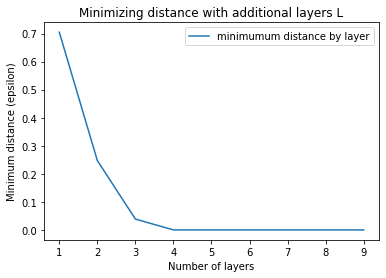

In [12]:
# Run the optimizer specifying the cost function and the maximum number of layers L to iterate over
optimizer(calculate_cost_function,10)

The minumum distance is optimized after 4 layers 

## 6. Bonus
Task: Try using other gates for the parametrized gates and see what happens.

We implemented two even gates in each layer instead of an odd and even gate 

In [15]:
# Just use even gates for layer L, new function called apply_L_layers_bonus

# Functions applies L layers (bonus)
def apply_L_layers_bonus(quantum_circuit, variational_parameters, layer):
    
    # Apply odd and even gates to the circuit L times
    for i in range(0,layer):
        quantum_circuit = apply_even_gate(quantum_circuit, variational_parameters[8*i:8*i+4])
        quantum_circuit = apply_even_gate(quantum_circuit, variational_parameters[8*i+4:8*i+8])
    
    return quantum_circuit

# cost function that calls the modified apply_L_layers_bonus function
NUM_SHOTS = 1000

def calculate_cost_function_bonus(parameters):
    
    # Number of Layers
    L = int(len(parameters)/8)
    
    # Generate a L layer quantum circuit with the varaitional parameters 
    q = QuantumRegister(4)
    qc = QuantumCircuit(q)
    qc = apply_L_layers_bonus(qc, parameters, L)
    
    # Tell Qiskit how to simulate our circuit
    backend = Aer.get_backend('statevector_simulator') 
    # Execute the simulation on the circuit and get and output state vector
    output_state = execute(qc, backend, shots = NUM_SHOTS).result().get_statevector()
    
    # Calculate teh cost, distance between output state and target phi state
    cost = sum([(output_state[i] - phi_state[i])*np.conjugate(output_state[i] - phi_state[i]) for i in range(2**4)])
    
    return cost

# Optimizer function that calls the modified apply_L_layers_bonus function
def optimizer_bonus(cost_function, max_Layers):
    
    # make lists of layers and costs for plotting later
    layer_list = []
    cost_list=[]
    
    for L in range(1,max_Layers):
        
        #initialize random variational parameters in the range of [0,2pi] for 8*L
        params=2*pi*np.random.rand(8*L) 

        # optimization
        ret=minimize(fun=calculate_cost_function_bonus,x0=params,method='BFGS',tol=0.0001,options={'maxiter':5000})
        cost=ret.fun
        layer_list.append(L)
        cost_list.append(cost)
        
        print("Layer",L , " has minimum distance of", cost)


    plt.plot(layer_list, cost_list, label="Bonus: Each layer is two even gates")
    plt.title('Bonus: Each layer is two even gates')
    plt.xlabel('Number of layers')
    plt.ylabel('Minimum distance (epsilon)')
    plt.legend()
    plt.show()
    return None

Layer 1  has minimum distance of 0.7044854784830017
Layer 2  has minimum distance of 0.2584444042637994
Layer 3  has minimum distance of 0.041873737353028476
Layer 4  has minimum distance of 3.239804806821096e-05
Layer 5  has minimum distance of 4.883430242131178e-07
Layer 6  has minimum distance of 1.9519489761583964e-07
Layer 7  has minimum distance of 1.9368945064409346e-07
Layer 8  has minimum distance of 1.0708352541094177e-07
Layer 9  has minimum distance of 4.407454463977575e-08


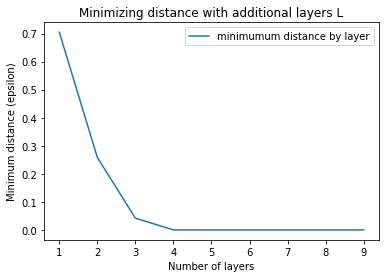

In [16]:
# Run the modified optimizer where each layer has two even gates
optimizer(calculate_cost_function_bonus,10)

The minumum distance is still optimized after 4 layers for the modified parameterization of gates 